In [1]:
%pip install --upgrade diffusers transformers

In [14]:
from pathlib import Path
import tqdm
import torch
import pandas as pd
import numpy as np
from diffusers import StableDiffusionPipeline
from transformers import pipeline, set_seed
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cv2
import os

In [15]:
class CFG:
    device = "cuda"
    seed = 42
    generator = torch.Generator(device).manual_seed(seed)
    image_gen_steps = 35
    image_gen_model_id = "stabilityai/stable-diffusion-2"
    image_gen_size = (400,400)
    image_gen_guidance_scale = 9
    prompt_gen_model_id = "gpt2"
    prompt_dataset_size = 6
    prompt_max_length = 12

In [16]:
# Load prompts from CSV
df = pd.read_csv('prompts.csv')
df['prompt'] = df['prompt'].str.replace(r'^"|"$', '', regex=True)  # Remove surrounding quotes if present

In [17]:
# Sample prompts according to config
sampled_prompts = df['prompt'].sample(
    n=CFG.prompt_dataset_size,
    random_state=CFG.seed
).tolist()

In [18]:
# Optionally truncate prompts to max length (in tokens or words)
def truncate_prompt(prompt, max_length):
    words = prompt.split()
    if len(words) > max_length:
        return ' '.join(words[:max_length])
    return prompt

truncated_prompts = [truncate_prompt(p, CFG.prompt_max_length) for p in sampled_prompts]

In [19]:
# Create a PyTorch Dataset
class PromptDataset(Dataset):
    def __init__(self, prompts):
        self.prompts = prompts

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, idx):
        return self.prompts[idx]

In [20]:
# Instantiate the dataset
prompt_dataset = PromptDataset(truncated_prompts)



In [21]:
# Example usage:
for i, prompt in enumerate(prompt_dataset):
    print(f"Prompt {i+1}: {prompt}")

Prompt 1: An underwater city with neon lights and sea creatures, sci-fi theme
Prompt 2: A medieval castle on a mountain surrounded by fog, matte painting style
Prompt 3: A steampunk airship floating above the clouds, intricate design
Prompt 4: A futuristic city skyline at sunset, ultra-detailed, cyberpunk
Prompt 5: A surreal dreamscape with melting clocks, inspired by Salvador Dali
Prompt 6: Portrait of a samurai warrior in armor, dramatic lighting


In [22]:
# === Generate and Save Images ===
os.makedirs("generated_images", exist_ok=True)

for idx, prompt in enumerate(truncated_prompts):
    print(f"Generating image for prompt {idx+1}: {prompt!r}")
    with torch.autocast(CFG.device):
        image = image_gen_model(
            prompt,
            num_inference_steps=CFG.image_gen_steps,
            guidance_scale=CFG.image_gen_guidance_scale,
            height=CFG.image_gen_size[1],
            width=CFG.image_gen_size[0],
            generator=CFG.generator
        ).images[0]
    image.save(f"generated_images/image_{idx+1}.png")

print("All images generated and saved in 'generated_images/' folder.")

Generating image for prompt 1: 'An underwater city with neon lights and sea creatures, sci-fi theme'


  0%|          | 0/35 [00:00<?, ?it/s]

Generating image for prompt 2: 'A medieval castle on a mountain surrounded by fog, matte painting style'


  0%|          | 0/35 [00:00<?, ?it/s]

Generating image for prompt 3: 'A steampunk airship floating above the clouds, intricate design'


  0%|          | 0/35 [00:00<?, ?it/s]

Generating image for prompt 4: 'A futuristic city skyline at sunset, ultra-detailed, cyberpunk'


  0%|          | 0/35 [00:00<?, ?it/s]

Generating image for prompt 5: 'A surreal dreamscape with melting clocks, inspired by Salvador Dali'


  0%|          | 0/35 [00:00<?, ?it/s]

Generating image for prompt 6: 'Portrait of a samurai warrior in armor, dramatic lighting'


  0%|          | 0/35 [00:00<?, ?it/s]

All images generated and saved in 'generated_images/' folder.


In [23]:
with open("generated_images/prompts.txt", "w") as f:
    for idx, prompt in enumerate(prompt_dataset):
        f.write(f"image_{idx+1}.png: {prompt}\n")


In [24]:
# === Load Stable Diffusion Pipeline ===
image_gen_model = StableDiffusionPipeline.from_pretrained(
    CFG.image_gen_model_id,
    torch_dtype=torch.float16,
    revision="fp16",
    use_auth_token="your_hugging_face_auth_token"  # <-- Replace with your token
)
image_gen_model = image_gen_model.to(CFG.device)

/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:285: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2 via `revision='fp16'`. This behavior is deprecated and will be removed in diffusers v1. One should use `variant='fp16'` instead. However, it appears that stabilityai/stable-diffusion-2 currently does not have the required variant filenames in the 'main' branch. 
 The Diffusers team and community would be very grateful if you could open an issue: https://github.com/huggingface/diffusers/issues/new with the title 'stabilityai/stable-diffusion-2 is missing fp16 files' so that the correct variant file can be added.
  warnings.warn(
Keyword arguments {'use_auth_token': 'your_hugging_face_auth_token'} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/d75b612d366d802b1753960de862a9270c8d55f1/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/d75b612d366d802b1753960de862a9270c8d55f1/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/d75b612d366d802b1753960de862a9270c8d55f1/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/d75b612d366d802b1753960de862a9270c8d55f1/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [ ]:
def generate_image(prompt, model):
    with torch.autocast(CFG.device):
        image = model(
            prompt,
            num_inference_steps=CFG.image_gen_steps,
            generator=CFG.generator,
            guidance_scale=CFG.image_gen_guidance_scale
        ).images[0]
    image = image.resize(CFG.image_gen_size)
    return image


  0%|          | 0/35 [00:00<?, ?it/s]

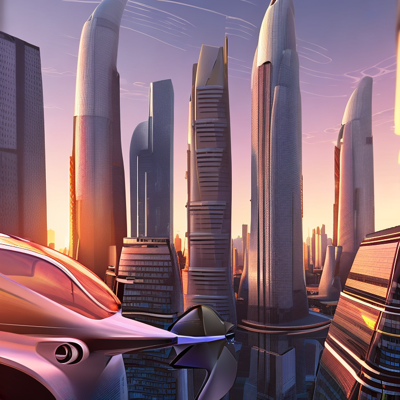

In [ ]:
generate_image("A photorealistic image of a futuristic city with flying cars and towering skyscrapers, with a vivid sunset in the background", image_gen_model)

  0%|          | 0/35 [00:00<?, ?it/s]

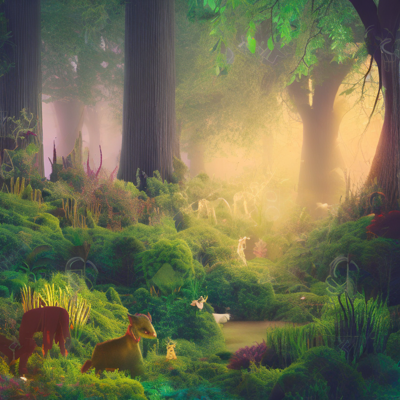

In [ ]:
generate_image("A mystical enchanted forest with glowing plants and magical creatures, bathed in soft dawn light", image_gen_model)


  0%|          | 0/35 [00:00<?, ?it/s]

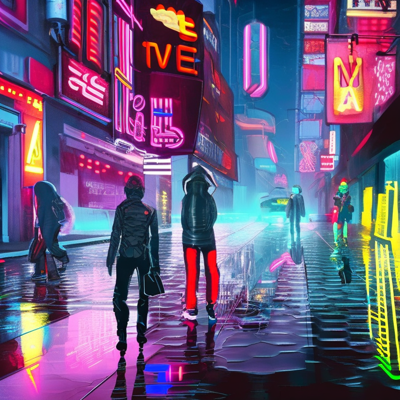

In [ ]:
generate_image("A vibrant cyberpunk street at night, neon signs glowing, people in futuristic outfits, and rain-soaked pavement reflecting colorful lights", image_gen_model)


  0%|          | 0/35 [00:00<?, ?it/s]

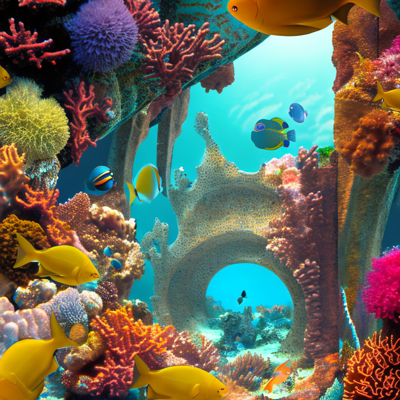

In [ ]:
generate_image("A stunning underwater city built among colorful coral reefs, with futuristic submarines and diverse marine life swimming around", image_gen_model)


  0%|          | 0/35 [00:00<?, ?it/s]

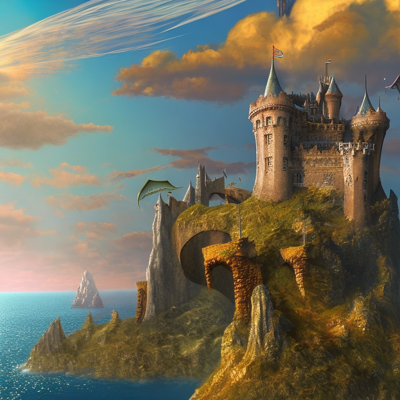

In [ ]:
generate_image("A fantasy landscape with a medieval castle on a cliff overlooking a vast ocean, with dragons soaring in the sky", image_gen_model)

  0%|          | 0/35 [00:00<?, ?it/s]

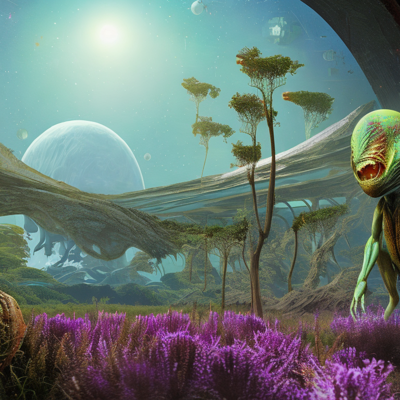

In [ ]:
generate_image("A sci-fi scene of an alien planet with exotic flora and fauna, with a glimpse of an advanced alien civilization in the background", image_gen_model)

  0%|          | 0/35 [00:00<?, ?it/s]

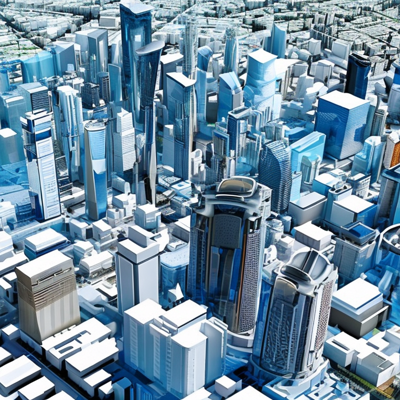

In [ ]:
generate_image("A photorealistic futuristic city showcasing AI-driven urban planning with digital twin interfaces overlaying smart buildings and autonomous drones monitoring infrastructure, under a clear blue sky", image_gen_model)


  0%|          | 0/35 [00:00<?, ?it/s]

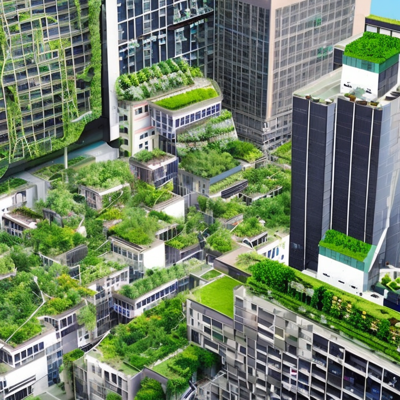

In [ ]:
generate_image("A vibrant smart city featuring green skyscrapers with vertical gardens, solar panels, and smart sensors monitoring energy and water use, with citizens enjoying clean parks and eco-friendly transport", image_gen_model)


  0%|          | 0/35 [00:00<?, ?it/s]

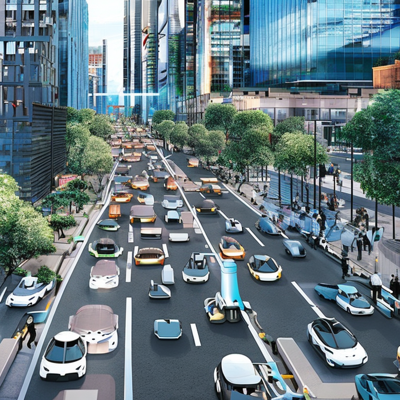

In [ ]:
generate_image("A bustling urban street with autonomous electric vehicles, flying taxis, intelligent traffic management systems, and bike-sharing stations, all integrated seamlessly with smart city IoT devices", image_gen_model)


  0%|          | 0/35 [00:00<?, ?it/s]

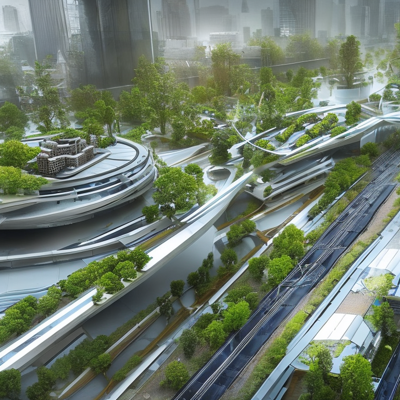

In [ ]:
generate_image("A futuristic cityscape designed to withstand climate change, with flood-resistant architecture, urban green spaces absorbing rainwater, and emergency response robots patrolling streets during a storm", image_gen_model)
